In [40]:
import math

import torch
from torch import tensor
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
import random
%matplotlib inline

from plot import *

## Optimizing Test Functions with EIpS

In [41]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.use_deterministic_algorithms(True)

dtype = torch.double

In [42]:
x_ = torch.arange(-1.0, 1.0, 0.01)
y_ = torch.arange(-1.0, 1.0, 0.01)
x_axis, y_axis = torch.meshgrid(x_, y_)
grid = torch.rot90(torch.stack((x_axis, y_axis), 2))

X_ = grid.reshape(len(x_)*len(y_), 2)

## Bayesian Optimization

kernel strategy:  replace_worst
::::::::::::::::::::::::::::::::::::::::::::::::::::
Sample  0
initialization
candidate:  tensor([-0.0075,  0.5364], dtype=torch.float64)
model score for candidate:  0.0819171632108554
iteration:       0
stored candidates:  0
current candidate:  tensor([[-0.9512, -0.8711]])  with value  tensor(0.1241)
iteration:       1.0
stored candidates:  1
current candidate:  tensor([[0.8879, 0.1592]])  with value  tensor(0.1114)
iteration:       2.0
stored candidates:  2
current candidate:  tensor([[-0.2621,  0.7108]])  with value  tensor(0.0609)
iteration:       3.0
stored candidates:  3
current candidate:  tensor([[-0.7105,  0.9557]])  with value  tensor(0.2270)
iteration:       4.0
stored candidates:  4
current candidate:  tensor([[-0.2728,  0.4464]])  with value  tensor(0.0701)
iteration:       5.0
stored candidates:  5
current candidate:  tensor([[-0.1015,  0.8901]])  with value  tensor(0.2260)
iteration:       6.0
stored candidates:  6
current candidate:  tens

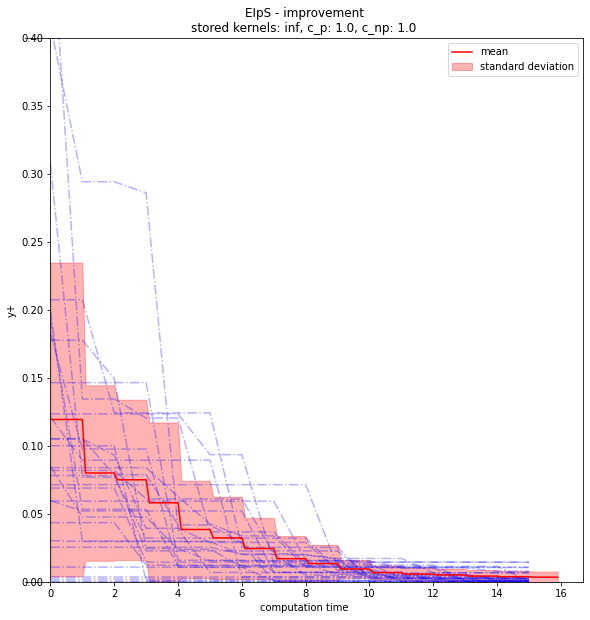

In [43]:
y_samples_all = []
def sample_bo(n_iters:int, compute_time_iter:bool, c_p=1, c_np=1, max_stored_kernels=3, kernel_strategy='replace_worst', plot=False):
    bounds = tensor([[x_[0], y_[0]], [x_[-1], y_[-1]]])
    X_samples = tensor([[2 * torch.rand((1)) - 1, 2 * torch.rand((1)) - 1]], dtype=torch.double)
    y_samples = torch.tensor([[himmelblau(X_samples[:,0], X_samples[:,1])]], dtype=torch.double)#.reshape(-1, 1)
    print("=======================")
    print("initialization")
    print("candidate: ", X_samples[0])
    print("model score for candidate: ", float(y_samples[0]))

    # EIpS stuff
    kernel_parameters = []
    kernel_evaluations = []
    total_compute_time = 0
    compute_time_steps = tensor([[0]], dtype=torch.double)
    current_iter = 0

    # measurements
    kernel_replacements = 0 # How often did BO use the kernel replacement strategy?
    kernels_visited = dict() # Which kernel matrix was used more than once with other samples in between?
    last_kernel = math.inf # Last visited kernel matrix

    while current_iter < n_iters:
        print("=======================")
        print("iteration:      ", current_iter)
        print("stored candidates: ", len(kernel_parameters))
        compute_time = c_np
        gp = SingleTaskGP(X_samples, y_samples)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_model(mll)

        EI = acqf.ExpectedImprovement(
            gp,
            y_samples.min(),
            maximize=False
        )
        best_candidate, acq_value = optimize_acqf(
            acq_function=EI,
            bounds=bounds,
            q=1,
            num_restarts=1,
            raw_samples=20
        )

        # calculate EIpS for new candidate proposal
        acq_value = acq_value/c_np

        # EIpS step
        best_candidate_ix = -1
        for ix, candidate_stored in enumerate(kernel_parameters):
            # Calculate EIpS for stored candidates
            bounds_candidate_stored = tensor([[candidate_stored[0], y_[0]],
                                              [candidate_stored[0], y_[-1]]])
            new_candidate_stored, acq_value_stored = optimize_acqf(
                acq_function=EI,
                bounds=bounds_candidate_stored,
                q=1,
                num_restarts=1,
                raw_samples=20
            )
            # calculate EIpS value of new candidate with stored kernel
            acq_value_stored = acq_value_stored/c_p

            # compare EIpS values against each other, pick the higher one
            if acq_value < acq_value_stored:
                acq_value = acq_value_stored
                best_candidate = new_candidate_stored
                compute_time = c_p

        # add chosen candidate to sample list, score model
        y_new_sample = himmelblau(best_candidate[0][0],
                                    best_candidate[0][1])

        # track kernel revisits
        float_best_candidate = float(best_candidate[0][0])
        if not last_kernel == float_best_candidate:
            if float_best_candidate in kernels_visited:
                kernels_visited[float_best_candidate] += 1
            else:
                kernels_visited[float_best_candidate] = 0
        last_kernel = float(best_candidate[0][0])

        # plot
        if plot:
            plot_bo(gp, EI, X_samples)

        print("current candidate: ", best_candidate, " with value ", y_new_sample)
        X_samples = torch.vstack((X_samples, best_candidate))
        y_samples = torch.vstack((y_samples, y_new_sample))
        if compute_time_iter:
            total_compute_time += compute_time
        else:
            total_compute_time += 1
        compute_time_steps = torch.vstack((compute_time_steps, tensor([total_compute_time])))

        # store new kernel matrix
        if len(kernel_parameters) < max_stored_kernels:
            #print("Added kernel matrix at iter ", i)
            kernel_evaluations.append(y_new_sample)     # model score
            kernel_parameters.append(best_candidate[0])    # scored model parameters
        elif kernel_strategy == "replace_worst":
            #print("replacing worst")
            val = min(kernel_evaluations) # smaller model score is better
            ix = kernel_evaluations.index(val)
            if val > y_new_sample: # if new model score better (smaller) than old, replace
                kernel_replacements += 1
                kernel_evaluations[ix] = y_new_sample   # model score
                kernel_parameters[ix] = best_candidate[0]  # scored model parameters
        elif kernel_strategy == "replace_oldest":
            #print("replacing oldest")
            kernel_replacements += 1
            kernel_evaluations.pop(0)
            kernel_parameters.pop(0)
            kernel_evaluations.append(y_new_sample)     # model score
            kernel_parameters.append(best_candidate[0])    # scored model parameters

        # increase iteration count by one if using limited iterations,
        # set to total compute time if using limited compute time
        if compute_time_iter:
            current_iter = total_compute_time
        else:
            current_iter += 1

    y_samples_all.append(y_samples)
    return y_samples, compute_time_steps, kernels_visited, kernel_replacements

# params
n_samples = 30
n_bo = 15

compute_time_iter = True # track computational time instead of iterations
kernel_strategies = ["replace_oldest", "replace_worst"]
kernel_strategy = kernel_strategies[1] # kernel replacement strategy
max_stored_kernels = math.inf # kernel matrix storage limit
c_p = 1. # cost of model evaluation with precomputed kernel matrix
c_np = 1. # cost of model evaluation

draw_plots = False # draw gp and acqf plots

# measurements
improvement_mean = torch.zeros((n_bo+1, 1))
compute_time_mean = 0.
sample_count_mean = 0.

improvement_list = []
compute_time_list = []

kernel_revisits_mean = 0
kernel_replacements_mean = 0
# bo sampling loop
p, ax = plt.subplots(figsize=(10, 10))
print("kernel strategy: ", kernel_strategy)
for i in range(0, n_samples):
    print("::::::::::::::::::::::::::::::::::::::::::::::::::::")
    print("Sample ", i)

    result, compute_time_steps, kernels_revisited, kernel_replacements = sample_bo(
        n_bo,
        compute_time_iter=compute_time_iter,
        c_p=c_p,
        c_np=c_np,
        max_stored_kernels=max_stored_kernels,
        kernel_strategy=kernel_strategy,
        plot=draw_plots)

    print("revisited kernels: ", kernels_revisited)
    print("kernel replacements: ", kernel_replacements)
    for val in kernels_revisited.values():
        kernel_revisits_mean += val
    kernel_replacements_mean += kernel_replacements

    improvement = torch.tensor([result[0]])

    for j in range(1, len(result)):
        if improvement[-1] > result[j]:
            improvement = torch.vstack((improvement, result[j]))
        else:
            improvement = torch.vstack((improvement, improvement[-1]))

    compute_time_mean += compute_time_steps[-1]
    sample_count_mean += len(result)-1
    improvement_list.append(improvement)
    compute_time_list.append(compute_time_steps)
    if compute_time_iter:
        ax.plot(compute_time_steps, improvement, '-.', color='blue', alpha = 0.3)
    else:
        ax.plot(np.arange(0, len(improvement), 1), improvement, '-.', color='blue', alpha = 0.3)


sample_count_mean *= 1/n_samples
compute_time_mean *= 1/n_samples
kernel_replacements_mean *= 1/n_samples
kernel_revisits_mean *= 1/n_samples

compute_time_steps = torch.arange(0, n_bo+1, 0.1)
improvement_list_scaled = []
for i in range(0, len(improvement_list)):
    current_improvement = improvement_list[i]
    current_compute_time = compute_time_list[i]
    scaled_improvement = torch.zeros((len(compute_time_steps)), 1)
    iter = 0
    compute_time = 0
    for j in range(0, len(compute_time_steps)):
        imp = current_improvement[iter]
        if not iter + 1 > len(current_compute_time) -1:
            compute_time = current_compute_time[iter+1]
        scaled_improvement[j] = imp
        if compute_time_steps[j] >= compute_time:
            if iter < len(current_improvement)-1:
                iter += 1
    improvement_list_scaled.append(scaled_improvement)

# calculate mean
improvement_mean = torch.zeros((len(compute_time_steps), 1))
for improvement in improvement_list_scaled:
    improvement_mean += improvement
improvement_mean *= 1/n_samples

# calculate var
improvement_var = torch.zeros((len(improvement_mean), 1))
for i in range(0, n_samples):
    improvement_var += torch.square(improvement_list_scaled[i] - improvement_mean)
improvement_var *= 1/n_samples
improvement_var = torch.sqrt(improvement_var)
print("compute time mean: ", compute_time_mean)
print("sample count mean: ", sample_count_mean)
print("kernel replacements mean: ", kernel_replacements_mean)
print("kernels revisited mean: ", kernel_revisits_mean)
print("improvement_mean: ", improvement_mean)
print("improvement_var: ", improvement_var)


ax.plot(compute_time_steps, improvement_mean, color='red', label='mean')
ax.fill_between(compute_time_steps,
                (improvement_mean - improvement_var).flatten(),
                (improvement_mean + improvement_var).flatten(),
                alpha=0.3,
                color='red',
                label='standard deviation')
if compute_time_iter:
    ax.set_xlabel("computation time")
else:
    ax.set_xlabel("iteration")

ax.set_ylabel("y+")
ax.set_title("EIpS - improvement\nstored kernels: " + str(max_stored_kernels) + ", c_p: " + str(c_p) + ", c_np: " + str(c_np))
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.set_ylim([0., 0.4])
ax.legend()
plt.show()